In [213]:
import sqlalchemy
import pandas as pd
import numpy as np

import mplfinance as mpf
from remy_workflow.patterns import patterns

import ipywidgets as widgets
import talib


In [214]:
db_connection_string = 'sqlite:///./Resources/products.db'
engine  = sqlalchemy.create_engine(db_connection_string)

inspector = sqlalchemy.inspect(engine)
table_names = inspector.get_table_names()
print(table_names)

['TSLA_1_Day_Candles', 'TSLA_1_Min_Candles', 'TSLA_Info']


In [215]:
# Update table names by looking at the list created above
# MSFT was used to create the example, replace it with the symbol you used
stock_ticker = 'TSLA'
daily_df = pd.read_sql_table(
    stock_ticker + '_1_Day_Candles', 
    con=engine, 
    index_col='Datetime',
    )
minutely_df = pd.read_sql_table(
    stock_ticker + '_1_Min_Candles', 
    con=engine, 
    index_col='Datetime'
    )

In [216]:
# print(daily_df.tail())

In [217]:
# print(minutely_df.tail())

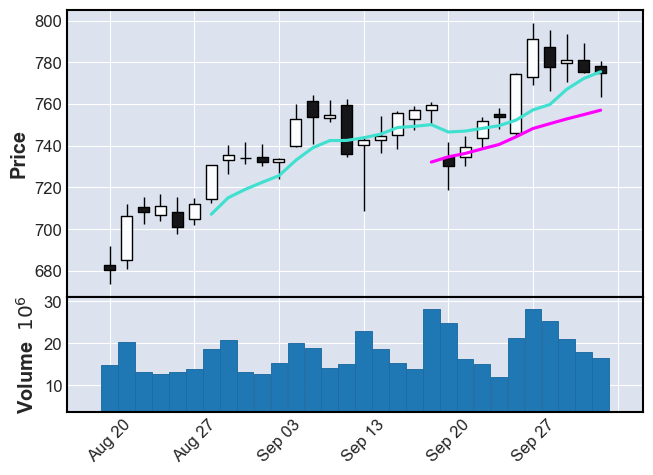

In [218]:
daily_slice = daily_df.iloc[-30:]
daily_candle_plot, ax = mpf.plot(
    # portfolio_list[0], 
    daily_slice, 
    type='candle', 
    volume=True, 
    returnfig=True,
    mav=(7,20),
    )


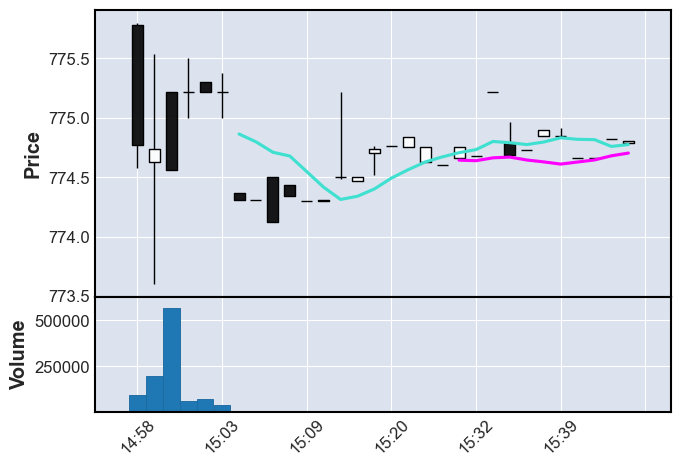

In [219]:
minutely_slice = minutely_df.iloc[-30:]
minutely_candle_plot, ax = mpf.plot(
    # portfolio_list[0], 
    minutely_slice, 
    type='candle', 
    volume=True, 
    returnfig=True,
    mav=(7,20),
    )


In [220]:
pattern_list = []
pattern_df = pd.DataFrame(list(patterns.items()), columns=['Index', 'Pattern'])
pattern_df = pattern_df.set_index('Index')
# print(pattern_df)
for pattern, p_name in patterns.items():
    pattern_list.append(pattern)

In [221]:
# vals = ['km', 'm', 'cm','mm']
sel = widgets.SelectMultiple(
        options=pattern_df['Pattern'],
        # options=pattern_list,
        value=['Doji'],
        rows=min(25, len(pattern_list)),
        # column_stack=True,
        description='Candle Pattern:'
    )
display(sel)


SelectMultiple(description='Candle Pattern:', index=(15,), options=('Two Crows', 'Three Black Crows', 'Three I…

In [222]:
df = daily_df
sel_pattern_list = list(pattern_df[pattern_df['Pattern'].isin(list(sel.value))].index)
for pattern in sel_pattern_list:
    pattern_function = getattr(talib, pattern)
    try:
        result = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])
        df[pattern] = result
    except Exception as e:
        print(f"{type(e)} Exception! {e}")
print(df.head())

             Open   High    Low  Close    Volume  CDLDOJI
Datetime                                                 
2010-06-29  3.800  5.000  3.508  4.778  93831500        0
2010-06-30  5.158  6.084  4.660  4.766  85935500        0
2010-07-01  5.000  5.184  4.054  4.392  41094000        0
2010-07-02  4.600  4.620  3.742  3.840  25699000        0
2010-07-06  4.000  4.000  3.166  3.222  34334500        0


In [223]:
df = minutely_df
sel_pattern_list = list(pattern_df[pattern_df['Pattern'].isin(list(sel.value))].index)
for pattern in sel_pattern_list:
    pattern_function = getattr(talib, pattern)
    try:
        result = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])
        df[pattern] = result
    except Exception as e:
        print(f"{type(e)} Exception! {e}")
print(df.head())

                       Open    High     Low   Close  Volume  CDLDOJI
Datetime                                                            
2021-09-01 15:45:00  732.70  732.70  732.50  732.50    1462        0
2021-09-01 15:46:00  732.70  732.70  732.07  732.07     951        0
2021-09-01 15:48:00  732.45  732.45  732.45  732.45     204        0
2021-09-01 15:51:00  732.20  732.26  732.19  732.20    2820        0
2021-09-01 15:52:00  732.40  732.40  732.20  732.30    1549        0


In [224]:
atr_function = getattr(talib, 'ATR')

atr_result = atr_function(df['High'], df['Low'], df['Close'], timeperiod=14)

atr_factor = 2.5

df['Trailing Stop'] = df['Close'] - (atr_result * atr_factor)
df = df.dropna()
print(df.head(20))
print(df.describe)

                       Open    High     Low   Close  Volume  CDLDOJI  \
Datetime                                                               
2021-09-01 16:07:00  732.51  732.51  732.51  732.51     371      100   
2021-09-01 16:09:00  732.46  732.46  732.00  732.34    1471        0   
2021-09-01 16:10:00  732.33  732.33  732.33  732.33     591      100   
2021-09-01 16:11:00  732.49  732.49  732.49  732.49     446      100   
2021-09-01 16:14:00  732.37  732.48  732.37  732.48     712        0   
2021-09-01 16:22:00  732.98  732.98  732.98  732.98     647      100   
2021-09-01 16:23:00  732.62  732.62  732.62  732.62     482      100   
2021-09-01 16:24:00  732.62  732.62  732.62  732.62     222      100   
2021-09-01 16:27:00  732.30  732.30  732.30  732.30     876      100   
2021-09-01 16:35:00  732.23  732.23  732.23  732.23     370      100   
2021-09-01 16:43:00  732.15  732.15  732.15  732.15     462      100   
2021-09-01 16:49:00  732.10  732.10  732.10  732.10     885     

In [225]:
df.loc[:, 'Long Entry'] = pd.NA

for index, row in df.iterrows():
    if row['CDLDOJI'] > 0:
        # row['Long Entry'] = 1
        df.loc[index, 'Long Entry'] = 1
    else:
        # row['Long Entry'] = 0
        df.loc[index, 'Long Entry'] = 0

        

C:\Users\remyd\.conda\envs\algo\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\remyd\.conda\envs\algo\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [226]:
df['Pct Change'] = df['Close'].pct_change()

C:\Users\remyd\.conda\envs\algo\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [227]:
df['Stop Loss'] = np.where(df['Long Entry']==1,df['Trailing Stop'],0.0)

C:\Users\remyd\.conda\envs\algo\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [228]:
# print(df.head())
print(df.tail())
print(df['Long Entry'].value_counts())

                       Open    High     Low   Close  Volume  CDLDOJI  \
Datetime                                                               
2021-10-01 15:39:00  774.85  774.91  774.85  774.85    2261      100   
2021-10-01 15:40:00  774.66  774.66  774.66  774.66     729      100   
2021-10-01 15:41:00  774.66  774.66  774.66  774.66     627      100   
2021-10-01 15:42:00  774.82  774.82  774.82  774.82     318      100   
2021-10-01 15:43:00  774.79  774.80  774.79  774.80     592        0   

                     Trailing Stop Long Entry  Pct Change   Stop Loss  
Datetime                                                               
2021-10-01 15:39:00     773.932858          1   -0.000065  773.932858  
2021-10-01 15:40:00     773.774440          1   -0.000245  773.774440  
2021-10-01 15:41:00     773.837694          1    0.000000  773.837694  
2021-10-01 15:42:00     774.027859          1    0.000207  774.027859  
2021-10-01 15:43:00     774.059083          0   -0.000026    0.

In [229]:
# df['Recalculated Stop Loss'] = pd.NA

# for index, row in df.iterrows():
    
#     if row['Initialize Stop Loss'] > 0.0:
#         df.loc[index, 'Recalculated Stop Loss'] = row['Initialize Stop Loss']

#     elif row['Initialize Stop Loss'] > 0.0 or row['Pct Change'] > 0.0:
#         if row['Trailing Stop'] > row['Recalculated Stop Loss'].shift(1):
#             df.loc[index,'Recalculated Stop Loss'] = row['Trailing Stop']
#         else:
#             df.loc[index,'Recalculated Stop Loss'] = row['Recalculated Stop Loss'].shift(1)
    
#     else:
#         df.loc[index,'Recalculated Stop Loss'] = row['Recalculated Stop Loss'].shift(1)

In [233]:
last_stop = 0.0
# df['Recalculated Stop Loss'] = pd.NA
for index, row in df.iterrows():
    if row['Pct Change'] > 0.0 and row['Trailing Stop'] > last_stop:
        df.loc[index,'Stop Loss'] = row['Trailing Stop']
    else:
        df.loc[index,'Stop Loss'] = last_stop

    last_stop = row['Stop Loss']


C:\Users\remyd\.conda\envs\algo\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


                     CDLDOJI  Trailing Stop Long Entry  Pct Change   Stop Loss
Datetime                                                                      
2021-09-01 16:07:00      100     731.822500          1         NaN    0.000000
2021-09-01 16:09:00        0     731.610536          0   -0.000232    0.000000
2021-09-01 16:10:00      100     731.650855          1   -0.000014    0.000000
2021-09-01 16:11:00      100     731.830794          1    0.000218  731.830794
2021-09-01 16:14:00        0     731.846451          0   -0.000014  731.830794
2021-09-01 16:22:00      100     732.302419          1    0.000683  732.302419
2021-09-01 16:23:00      100     731.926532          1   -0.000491  732.302419
2021-09-01 16:24:00      100     731.976065          1    0.000000  732.302419
2021-09-01 16:27:00      100     731.644918          1   -0.000437  732.302419
2021-09-01 16:35:00      100     731.609209          1   -0.000096  732.302419
2021-09-01 16:43:00      100     731.559266         

In [234]:
print(df.iloc[:, -5:].head(20))

                     CDLDOJI  Trailing Stop Long Entry  Pct Change   Stop Loss
Datetime                                                                      
2021-09-01 16:07:00      100     731.822500          1         NaN    0.000000
2021-09-01 16:09:00        0     731.610536          0   -0.000232    0.000000
2021-09-01 16:10:00      100     731.650855          1   -0.000014    0.000000
2021-09-01 16:11:00      100     731.830794          1    0.000218  731.830794
2021-09-01 16:14:00        0     731.846451          0   -0.000014  731.830794
2021-09-01 16:22:00      100     732.302419          1    0.000683  732.302419
2021-09-01 16:23:00      100     731.926532          1   -0.000491  732.302419
2021-09-01 16:24:00      100     731.976065          1    0.000000  732.302419
2021-09-01 16:27:00      100     731.644918          1   -0.000437  732.302419
2021-09-01 16:35:00      100     731.609209          1   -0.000096  732.302419
2021-09-01 16:43:00      100     731.559266         